# Convert NetCDF to KMZ

We first load useful libraries

In [57]:
from simplekml import (Kml, OverlayXY, ScreenXY, Units, RotationXY,
                       AltitudeMode, Camera)
import netCDF4
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from palettable import colorbrewer
import warnings
warnings.filterwarnings("ignore")

We open the file as NetCDF format

In [64]:
def make_kml(llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat,
             figs, colorbar=None, **kw):
    """TODO: LatLon bbox, list of figs, optional colorbar figure,
    and several simplekml kw..."""

    kml = Kml()
    altitude = kw.pop('altitude', 2e7)
    roll = kw.pop('roll', 0)
    tilt = kw.pop('tilt', 0)
    altitudemode = kw.pop('altitudemode', AltitudeMode.relativetoground)
    camera = Camera(latitude=np.mean([urcrnrlat, llcrnrlat]),
                    longitude=np.mean([urcrnrlon, llcrnrlon]),
                    altitude=altitude, roll=roll, tilt=tilt,
                    altitudemode=altitudemode)

    kml.document.camera = camera
    draworder = 0
    for fig in figs:  # NOTE: Overlays are limited to the same bbox.
        draworder += 1
        ground = kml.newgroundoverlay(name='GroundOverlay')
        ground.draworder = draworder
        ground.visibility = kw.pop('visibility', 1)
        ground.name = kw.pop('name', 'overlay')
        ground.color = kw.pop('color', '9effffff')
        ground.atomauthor = kw.pop('author', 'name surname')
        ground.latlonbox.rotation = kw.pop('rotation', 0)
        ground.description = kw.pop('description', 'Matplotlib figure')
        ground.gxaltitudemode = kw.pop('gxaltitudemode',
                                       'clampToSeaFloor')
        ground.icon.href = fig
        ground.latlonbox.east = llcrnrlon
        ground.latlonbox.south = llcrnrlat
        ground.latlonbox.north = urcrnrlat
        ground.latlonbox.west = urcrnrlon

    if colorbar:  # Options for colorbar are hard-coded (to avoid a big mess).
        screen = kml.newscreenoverlay(name='ScreenOverlay')
        screen.icon.href = colorbar
        screen.overlayxy = OverlayXY(x=0, y=0,
                                     xunits=Units.fraction,
                                     yunits=Units.fraction)
        screen.screenxy = ScreenXY(x=0.015, y=0.075,
                                   xunits=Units.fraction,
                                   yunits=Units.fraction)
        screen.rotationXY = RotationXY(x=0.5, y=0.5,
                                       xunits=Units.fraction,
                                       yunits=Units.fraction)
        screen.size.x = 0
        screen.size.y = 0
        screen.size.xunits = Units.fraction
        screen.size.yunits = Units.fraction
        screen.visibility = 1

    kmzfile = kw.pop('kmzfile', 'overlay.kmz')
    kml.savekmz(kmzfile)

We extract the coordinates and the variables to be included into the JSON file

In [59]:
def gearth_fig(llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat, pixels=1024):
    """Return a Matplotlib `fig` and `ax` handles for a Google-Earth Image."""
    aspect = np.cos(np.mean([llcrnrlat, urcrnrlat]) * np.pi/180.0)
    xsize = np.ptp([urcrnrlon, llcrnrlon]) * aspect
    ysize = np.ptp([urcrnrlat, llcrnrlat])
    aspect = ysize / xsize

    if aspect > 1.0:
        figsize = (10.0 / aspect, 10.0)
    else:
        figsize = (10.0, 10.0 * aspect)

    if False:
        plt.ioff()  # Make `True` to prevent the KML components from poping-up.
    fig = plt.figure(figsize=figsize,
                     frameon=False,
                     dpi=pixels//10)
    # KML friendly image.  If using basemap try: `fix_aspect=False`.
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(llcrnrlon, urcrnrlon)
    ax.set_ylim(llcrnrlat, urcrnrlat)
    return fig, ax

We create empty arrays to store the coordinates and the variable

In [60]:
data = netCDF4.Dataset('../../DATA/wind.nc')
lons = data.variables['FNOCXN79_64'][:]
lats = data.variables['FNOCY'][:]
unwd = data.variables['UWND'][0,:,:]
lat, lon = np.meshgrid(lats, lons)
mdt=np.transpose(unwd) 
lon.min()

-180.0

We assign the values to the arrays iterating along the coordinates length every other two gridpoints 

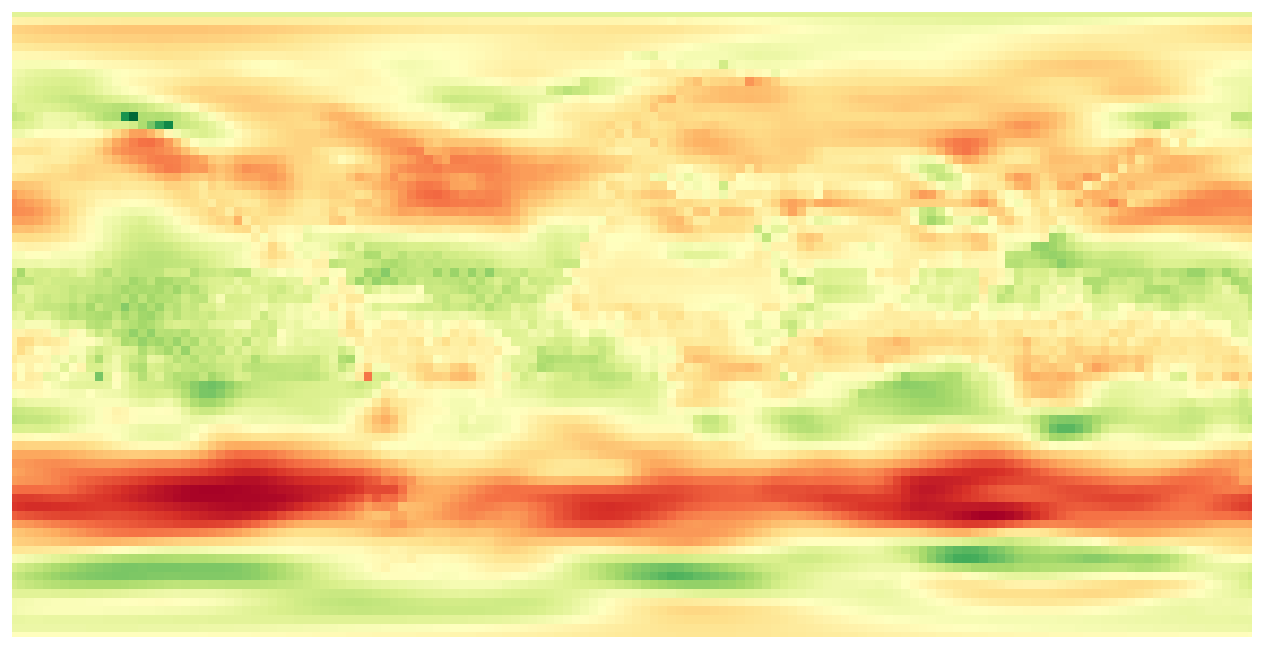

In [61]:
pixels = 124 * 10
cmap = colorbrewer.get_map('RdYlGn', 'diverging', 11, reverse=True).mpl_colormap
fig, ax = gearth_fig(llcrnrlon=lon.min(),
                     llcrnrlat=lat.min(),
                     urcrnrlon=lon.max(),
                     urcrnrlat=lat.max(),
                     pixels=pixels)
cs = ax.pcolormesh(lon, lat, mdt, cmap=cmap)
ax.set_axis_off()
fig.savefig('overlay1.png', transparent=False, format='png')

We store the arrays in pandas

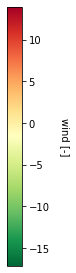

In [62]:
fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('wind [-]', rotation=-90, color='k', labelpad=20)
fig.savefig('legend.png', transparent=False, format='png')  # Change transparent to True if your colorbar is not on space :)

In [63]:
make_kml(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
         urcrnrlon=lon.max(), urcrnrlat=lat.max(),
         figs=['overlay1.png'],
         colorbar='legend.png',
         kmzfile='wind.kml', name='WIND')